In [48]:
import os
import torch
import pickle as pkl
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_utils import (
    results2df,
)
from plot_utils import plot_behavior_distribution
from sklearn.dummy import DummyClassifier
from torchmetrics.functional.classification import (
    multilabel_average_precision,
    multilabel_f1_score,
)
from matplotlib.colors import rgb2hex

**Data Loading**

In [28]:
metadata_file = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/metadata/with_negative_pairing/new_metadata.csv"
behaviours_file = "../dataset/metadata/behaviours.txt"
segments_file = "../dataset/metadata/segments.txt"


metadata_df = pd.read_csv(metadata_file)

with open(behaviours_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segments_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

dummy_aps = [
    0.0235,
    0.0531,
    0.1467,
    0.1292,
    0.0346,
    0.2582,
    0.0776,
    0.1038,
    0.0155,
    0.0115,
    0.4553,
    0.1002,
    0.5724,
    0.0563,
]

In [29]:
def calculate_metrics(df, round_to=3, show_per_class=True):
    map_values = multilabel_average_precision(
        torch.tensor(np.stack(df["pred"])),
        torch.tensor(np.stack(df["label"])),
        num_labels=14,
        average="none",
        # thresholds=200,
    )
    avg_map = round(map_values.mean().item(), round_to)
    if show_per_class:
        map_values_list = []
        for v in map_values:
            map_v = round(v.item(), round_to)
            map_values_list.append(map_v)

        return map_values_list
    return avg_map

In [30]:
val_results = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results"

results_df = None

# Get paths to all pickle files
val_paths = []
for root, dirs, files in os.walk(val_results):
    for file in files:
        if file.endswith(".pkl"):
            val_paths.append(os.path.join(root, file))

for val_path in val_paths:

    col_name = val_path.split("/")[-2]
    with open(
        val_path,
        "rb",
    ) as f:
        val_data = pkl.load(f)

    train_df, val_df = results2df(
        val_data, val_data, metadata_df, right_on="subject_id_fg"
    )

    if results_df is None:
        results_df = pd.DataFrame(
            {
                "behaviour": behaviours,
                "segment": segments,
                f"{col_name}": calculate_metrics(val_df),
            }
        )
    else:
        results_df[col_name] = calculate_metrics(val_df)

results_df["dummy_aps"] = dummy_aps

/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/data_utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))
/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/data_utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))
/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/data_utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df["pred"]

In [31]:
results_df

,behaviour,segment,model=slow_r50_e200_fg_minus_bg_sched=linear_agg=conv,model=slow_r50_exclusive_utms_fg_only,model=slow_r50_e200_fg_minus_bg_sched=linear_agg=max_pool,model=slow_r50_e200_fg_minus_bg_ft,model=slow_r50_e200_fg_minus_bg_sched=linear_agg=avg_pool,model=slow_r50_e200_fg_minus_bg_sched=none_agg=avg_pool,model=slow_r50_e300_bg-only,model=slow_r50_e200_baseline_results,dummy_aps
0,aggression,few_shot,0.018,0.065,0.127,0.404,0.478,0.358,0.122,0.409,0.0235
1,bipedal,tail,0.039,0.058,0.138,0.354,0.337,0.314,0.097,0.329,0.0531
2,camera_reaction,tail,0.107,0.519,0.303,0.499,0.466,0.457,0.308,0.448,0.1467
3,climbing,tail,0.118,0.553,0.428,0.700,0.711,0.672,0.484,0.696,0.1292
4,display,few_shot,0.029,0.084,0.187,0.561,0.581,0.473,0.219,0.563,0.0346
5,feeding,head,0.275,0.466,0.684,0.802,0.797,0.764,0.669,0.840,0.2582
6,grooming,tail,0.070,0.167,0.130,0.248,0.214,0.159,0.130,0.211,0.0776
7,object_carrying,tail,0.075,0.340,0.211,0.365,0.359,0.344,0.209,0.342,0.1038
8,piloerection,few_shot,0.010,0.071,0.037,0.198,0.252,0.164,0.056,0.231,0.0155
9,playing,few_shot,0.009,0.007,0.029,0.043,0.040,0.049,0.014,0.040,0.0115


In [34]:
results_df[
    [
        "behaviour",
        "dummy_aps",
        "model=slow_r50_exclusive_utms_fg_only",
        "model=slow_r50_e200_baseline_results",
    ]
].sort_values(by="dummy_aps", ascending=False)

,behaviour,dummy_aps,model=slow_r50_exclusive_utms_fg_only,model=slow_r50_e200_baseline_results
12,travel,0.5724,0.903,0.921
10,resting,0.4553,0.535,0.772
5,feeding,0.2582,0.466,0.840
2,camera_reaction,0.1467,0.519,0.448
3,climbing,0.1292,0.553,0.696
7,object_carrying,0.1038,0.340,0.342
11,tool_use,0.1002,0.421,0.871
6,grooming,0.0776,0.167,0.211
13,vocalisation,0.0563,0.059,0.338
1,bipedal,0.0531,0.058,0.329


In [7]:
bg_df = results_df[
    [
        "behaviour",
        "dummy_aps",
        "model=slow_r50_e300_bg-only",
        "model=slow_r50_e200_baseline_results",
    ]
]

In [8]:
bg_df["dummy_bg_diff"] = bg_df["model=slow_r50_e300_bg-only"] - bg_df["dummy_aps"]
bg_df["baseline_bg_diff"] = (
    bg_df["model=slow_r50_e200_baseline_results"] - bg_df["model=slow_r50_e300_bg-only"]
)

<ipython-input-8-41ded49b9867>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_df["dummy_bg_diff"] = bg_df["model=slow_r50_e300_bg-only"] - bg_df["dummy_aps"]
<ipython-input-8-41ded49b9867>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_df["baseline_bg_diff"] = (


In [9]:
bg_df.sort_values(by=["dummy_bg_diff"], ascending=False)

,behaviour,dummy_aps,model=slow_r50_e300_bg-only,model=slow_r50_e200_baseline_results,dummy_bg_diff,baseline_bg_diff
11,tool_use,0.1002,0.637,0.871,0.5368,0.234
5,feeding,0.2582,0.669,0.840,0.4108,0.171
3,climbing,0.1292,0.484,0.696,0.3548,0.212
4,display,0.0346,0.219,0.563,0.1844,0.344
10,resting,0.4553,0.623,0.772,0.1677,0.149
2,camera_reaction,0.1467,0.308,0.448,0.1613,0.140
7,object_carrying,0.1038,0.209,0.342,0.1052,0.133
0,aggression,0.0235,0.122,0.409,0.0985,0.287
13,vocalisation,0.0563,0.130,0.338,0.0737,0.208
6,grooming,0.0776,0.130,0.211,0.0524,0.081


**Exclusive results**

In [41]:
with open(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results/model=slow_r50_exclusive_utms_fg_only/model=slow_r50_exclusive_utms_fg_only_feats.pkl",
    "rb",
) as f:
    val_data = pkl.load(f)

with open(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results/model=slow_r50_exclusive_utms_fg_only_train/model=slow_r50_exclusive_utms_fg_only_train_feats.pkl",
    "rb",
) as f:
    train_data = pkl.load(f)

train_df, val_df = results2df(
    train_data, val_data, metadata_df, right_on="subject_id_fg"
)

/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/data_utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))


In [56]:
dummy_aps = [
    0.0206,
    0.0453,
    0.1432,
    0.1658,
    0.0227,
    0.2533,
    0.0618,
    0.1267,
    0.0175,
    0.0062,
    0.4027,
    0.1432,
    0.62,
    0.0494,
]

exclusive_df = pd.DataFrame(
    {
        "behaviour": behaviours,
        "segment": segments,
        "train_ap": calculate_metrics(train_df),
        "val_ap": calculate_metrics(val_df),
        "dummy_ap": dummy_aps,
    }
)

In [61]:
exclusive_df.sort_values(by="val_ap", ascending=False)

,behaviour,segment,train_ap,val_ap,dummy_ap
12,travel,head,0.994,0.903,0.6200
3,climbing,tail,0.998,0.553,0.1658
10,resting,head,0.997,0.535,0.4027
2,camera_reaction,tail,0.995,0.519,0.1432
5,feeding,head,0.998,0.466,0.2533
11,tool_use,tail,0.999,0.421,0.1432
7,object_carrying,tail,0.992,0.340,0.1267
6,grooming,tail,0.970,0.167,0.0618
4,display,few_shot,0.992,0.084,0.0227
8,piloerection,few_shot,0.999,0.071,0.0175


In [64]:
for s in exclusive_df.segment.unique():
    print(
        s,
        exclusive_df[exclusive_df.segment == s][exclusive_df.columns[2:]][
            "val_ap"
        ].mean(),
    )

few_shot 0.05675000000000001
tail 0.3024285714285715
head 0.6346666666666667


[  51   97  259  247   87  523  134  171   27   25  916  145 1063  112]


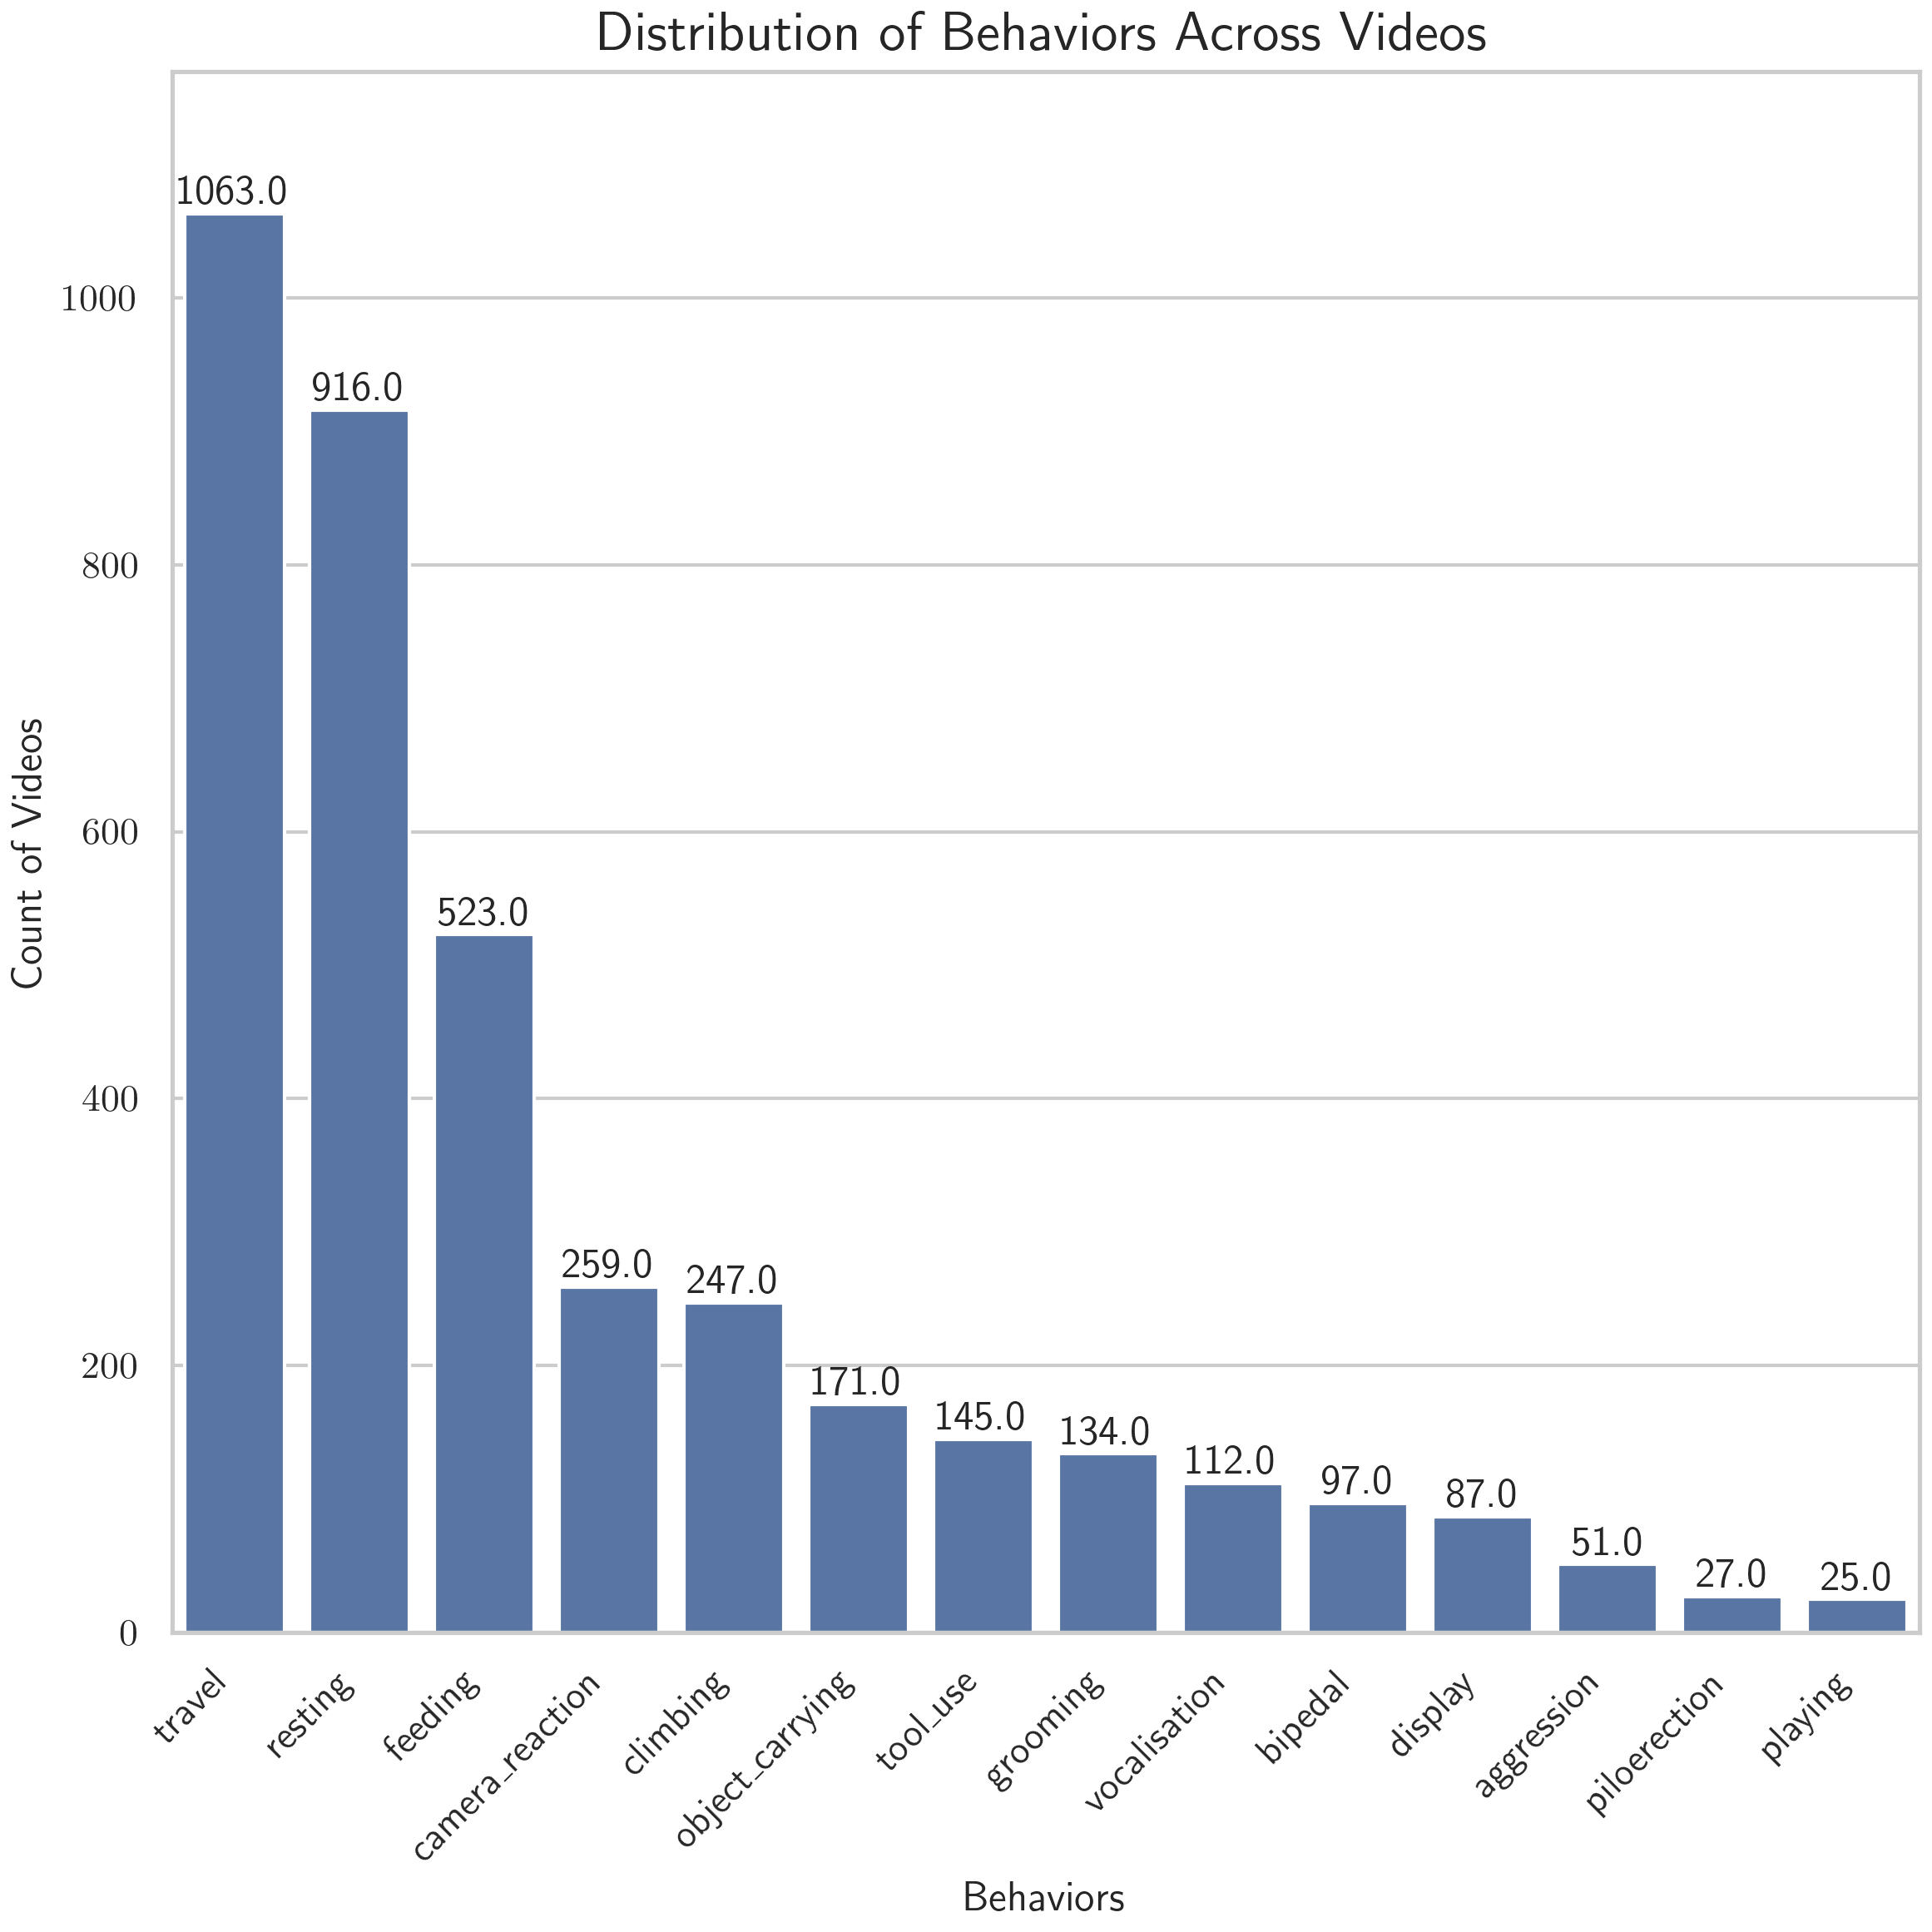

In [44]:
plot_behavior_distribution(train_df, behaviours, "count")

[ 20  44 139 161  22 246  60 123  17   6 391 139 602  48]


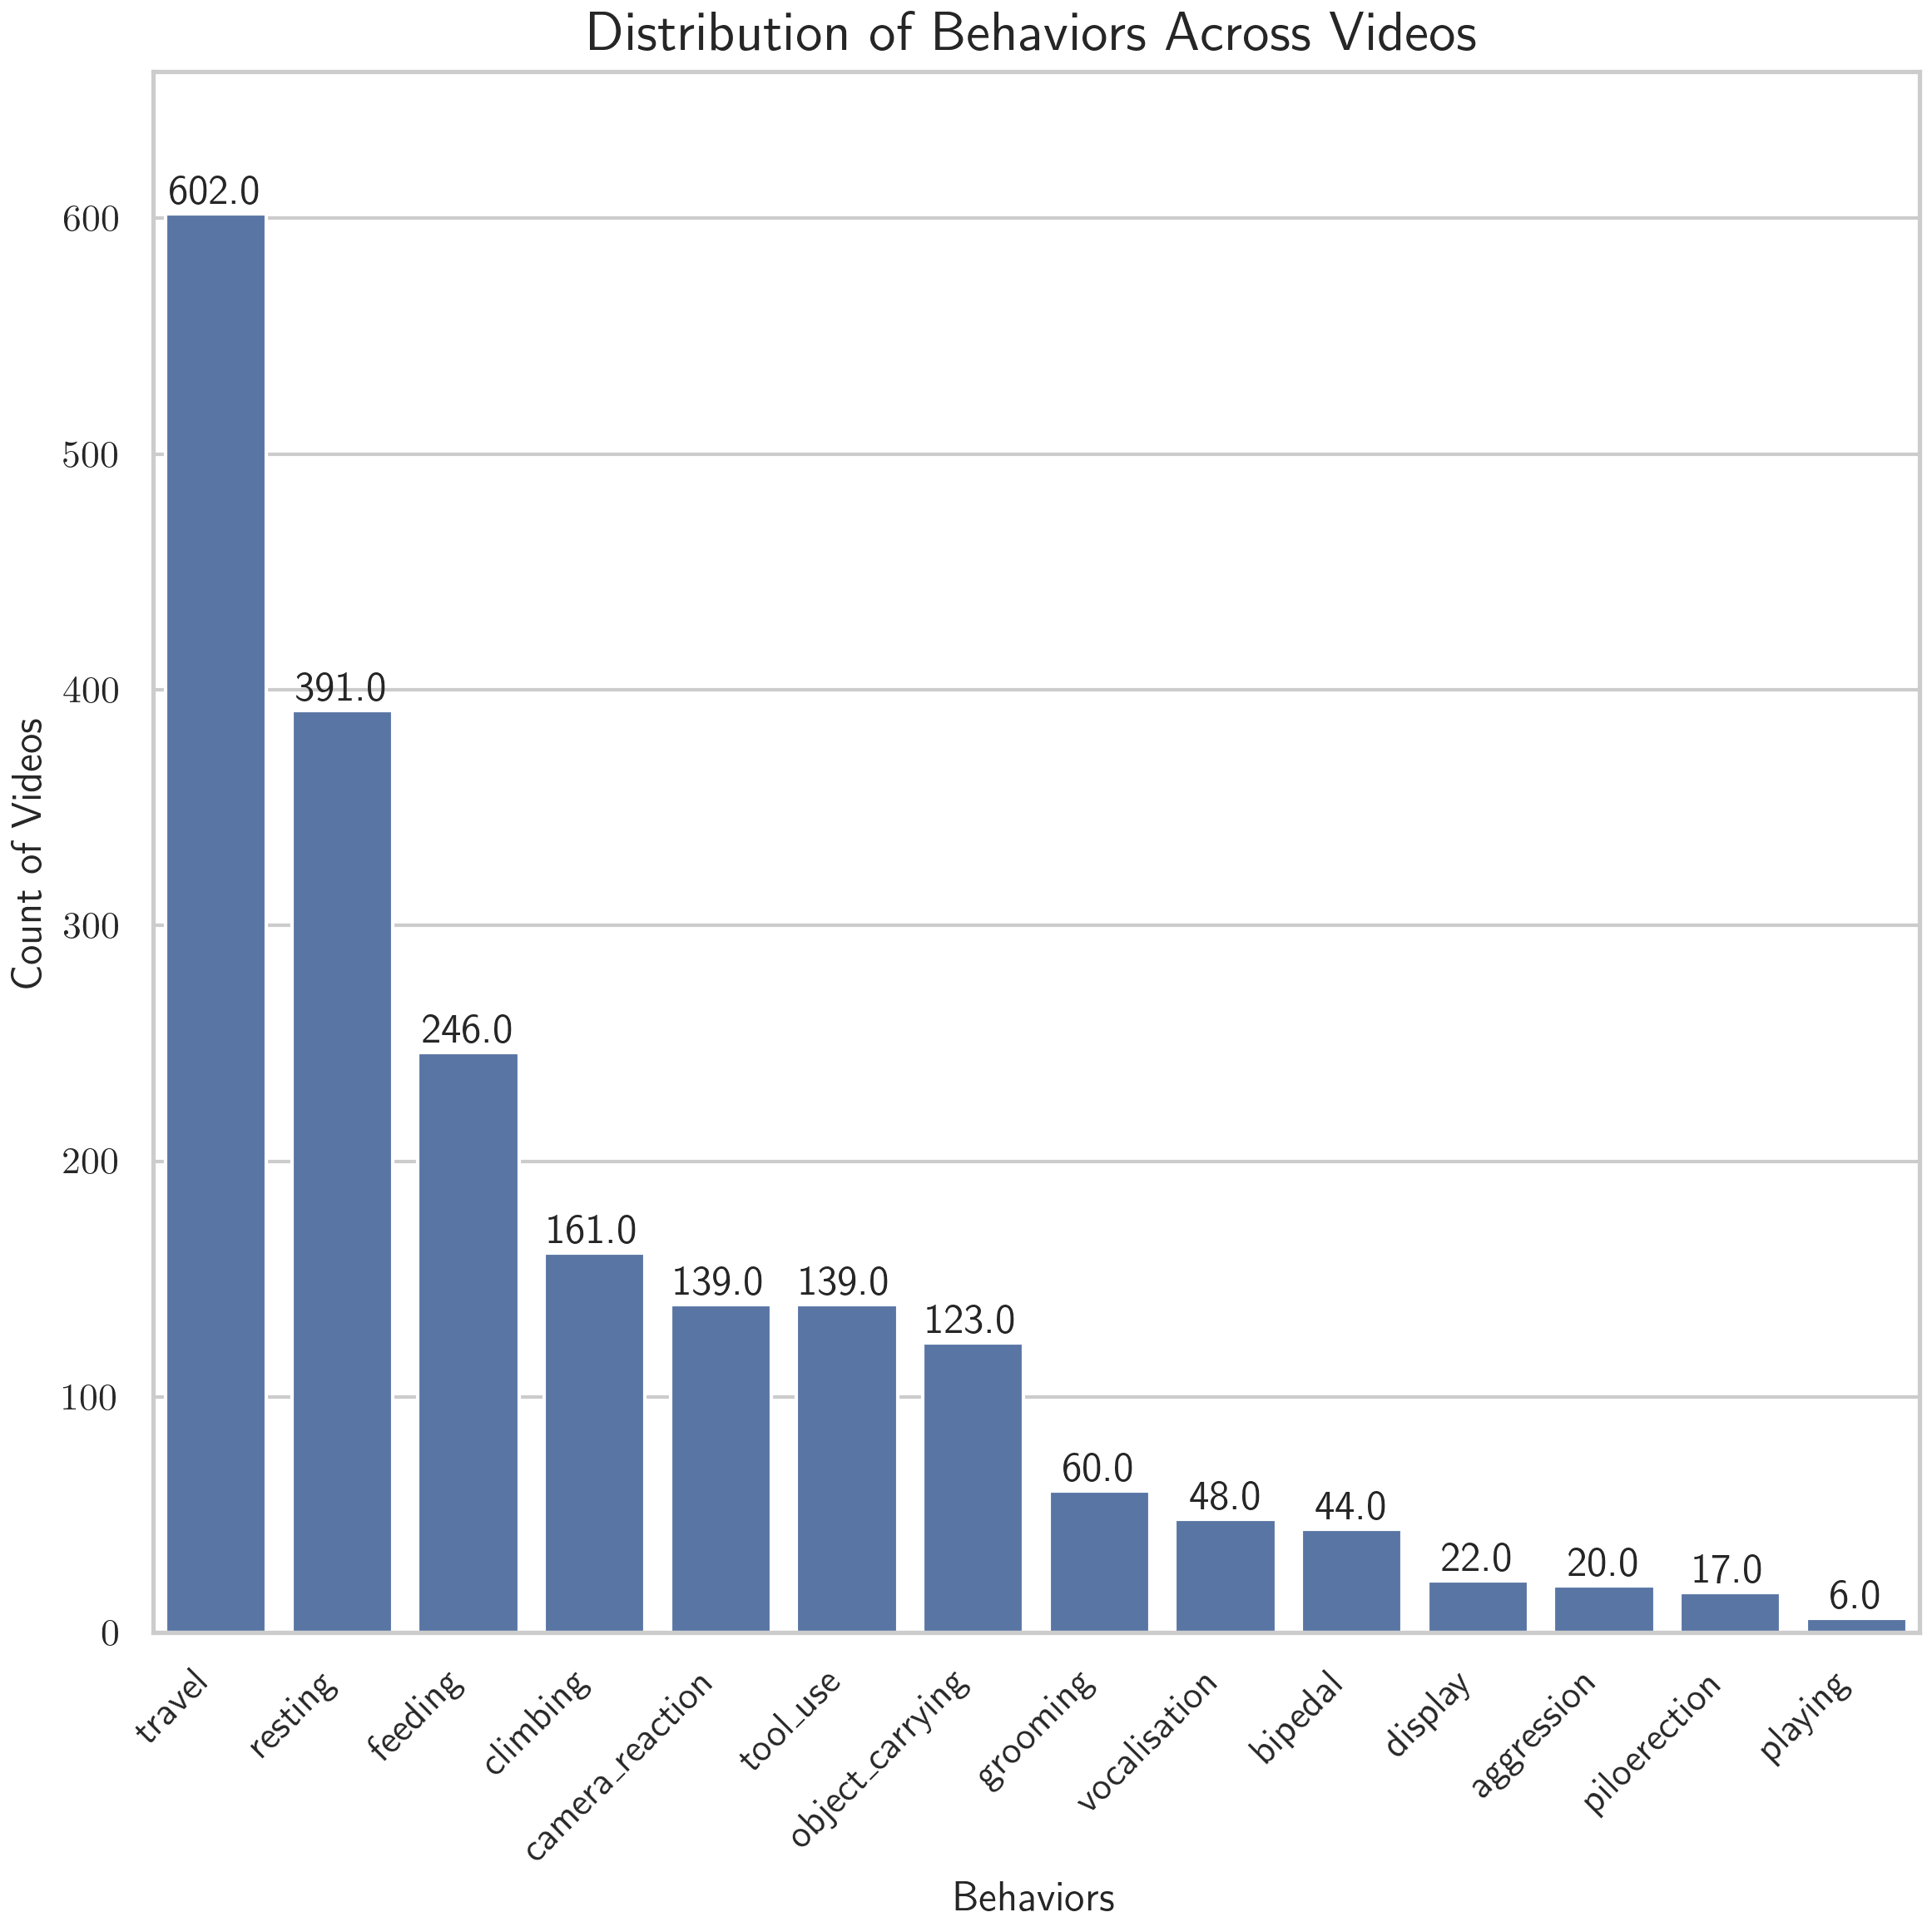

In [46]:
plot_behavior_distribution(val_df, behaviours, "count")

In [50]:
# Dummy classifier

# Iterative train test split
X_train, y_train, X_test, y_test = (
    train_df["name"].values,
    train_df["label"].values,
    val_df["name"].values,
    val_df["label"].values,
)

In [51]:
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

y_train = np.vstack(y_train)
y_test = np.vstack(y_test)

In [52]:
for strat in ["most_frequent", "prior", "stratified", "uniform"]:
    dummy_clf = DummyClassifier(strategy=strat)
    dummy_clf.fit(X_train, y_train)
    predictions = dummy_clf.predict(X_test)

    # Convert preds and labels to tensors
    predictions = torch.tensor(predictions, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    path_to_labels = "../dataset/metadata/behaviours.txt"
    with open(path_to_labels) as f:
        class_names = f.read().splitlines()

    macro_average_precision = multilabel_average_precision(
        predictions, y_test.long(), num_labels=14, average="macro"
    )
    per_class_average_precision = multilabel_average_precision(
        predictions, y_test.long(), num_labels=14, average=None
    )
    per_class_average_precision = [
        {f"{class_names[idx]}": ap.item()}
        for idx, ap in enumerate(per_class_average_precision)
    ]
    print(f"Strategy: {strat}")
    print(f"mAP: {round(macro_average_precision.item(),4)}")
    for seg, ap in zip(segments, per_class_average_precision):
        for k, v in ap.items():
            print(f"{k}, {seg}, {round(v, 4)}")
    print("\n")

Strategy: most_frequent
mAP: 0.1484
aggression, few_shot, 0.0206
bipedal, tail, 0.0453
camera_reaction, tail, 0.1432
climbing, tail, 0.1658
display, few_shot, 0.0227
feeding, head, 0.2533
grooming, tail, 0.0618
object_carrying, tail, 0.1267
piloerection, few_shot, 0.0175
playing, few_shot, 0.0062
resting, head, 0.4027
tool_use, tail, 0.1432
travel, head, 0.62
vocalisation, tail, 0.0494


Strategy: prior
mAP: 0.1484
aggression, few_shot, 0.0206
bipedal, tail, 0.0453
camera_reaction, tail, 0.1432
climbing, tail, 0.1658
display, few_shot, 0.0227
feeding, head, 0.2533
grooming, tail, 0.0618
object_carrying, tail, 0.1267
piloerection, few_shot, 0.0175
playing, few_shot, 0.0062
resting, head, 0.4027
tool_use, tail, 0.1432
travel, head, 0.62
vocalisation, tail, 0.0494


Strategy: stratified
mAP: 0.1504
aggression, few_shot, 0.0206
bipedal, tail, 0.0453
camera_reaction, tail, 0.1487
climbing, tail, 0.1655
display, few_shot, 0.0227
feeding, head, 0.2525
grooming, tail, 0.0633
object_carrying, t

<ipython-input-52-c806c01f677b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)
